# 通し課題　Day1 →　Day2→　Day3

　kaggleのデータセット「Kickstarter Projects」を用いてクラウドファンデイングが成功するか(state)を予測する。
 
 - day1:前処理　不要なデータを削除してから質的変数の変換　ロジスティック回帰
 - day2:相関係数確認　標準化　ホールドアウト法　交差検証　SVM（ハイパーパラメータ手動設定・グリッドサーチ）
 - day3:特徴選択　決定木、アダブースト、ニューラルネットワーク

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
import seaborn as sns
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.preprocessing import StandardScaler #標準化に関する関数
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


In [2]:
#データ読み込み
df_ks=pd.read_csv("ks-projects-201801.csv")
#df_ks=df_ks.iloc[0:10000,:]


#### Day1前処理・ロジスティック回帰

データの統計情報確認・前処理

In [3]:
#データ情報
df_ks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


欠損値は「name」と「usd pledged」のみ

In [4]:
#データ情報
df_ks.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


各列の意味を確認
- ID：個別ID
- name:名前
- category：詳細カテゴリー
- main_category：カテゴリー
- currency：通貨
- deadline：締め切りの日付
- goal：目標額
- launched：開始日
- pledged：集まった額
- state：状態
- backers：支援者数
- country：国
- usd pledged：アメリカドル換算の集計額
- usd_pledged_real：アメリカドル換算の集計額(fixerAPI換算)
- usd_goal_real：アメリカドル換算の目標額(fixerAPI換算)

In [5]:
#予測に使用しない「ID]や[name]列を削除
df_ks_pre=df_ks.drop(columns=["ID","name"])
#開始後に値が決定する列を削除
df_ks_pre=df_ks_pre.drop(columns=["pledged","backers","usd pledged","usd_pledged_real"])
#意味が重複する列を削除
df_ks_pre=df_ks_pre.drop(columns=["goal"])

In [6]:
#不要な列削除後のデータ情報
df_ks_pre.head()

,category,main_category,currency,deadline,launched,state,country,usd_goal_real
0,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00
3,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00
4,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,US,19500.00


In [7]:
#欠損値確認
df_ks_pre.isnull().sum()

category         0
main_category    0
currency         0
deadline         0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

欠損値なし

In [8]:
#結果が出ているデータのみ抽出
df_ks_pre=df_ks_pre.loc[(df_ks_pre['state']=='successful') | (df_ks_pre['state']=='failed')]

#結果を数値に変換
df_ks_pre.loc[df_ks_pre['state']=='successful','state_num']=1
df_ks_pre.loc[df_ks_pre['state']=='failed','state_num']=0

#変換した元の列を削除
df_ks_pre=df_ks_pre.drop(columns=['state'])

#インデックス振り直し
df_ks_pre.reset_index(inplace = True)
df_ks_pre=df_ks_pre.drop(columns=['index'])

df_ks_pre.head()
print(df_ks_pre.describe())

       usd_goal_real      state_num
count   3.316750e+05  331675.000000
mean    4.151000e+04       0.403877
std     1.108930e+06       0.490674
min     1.000000e-02       0.000000
25%     2.000000e+03       0.000000
50%     5.000000e+03       0.000000
75%     1.500000e+04       1.000000
max     1.663614e+08       1.000000


In [9]:
#カテゴリ変数と思われる項目の値を確認
print(df_ks_pre["category"].value_counts())
print(df_ks_pre["main_category"].value_counts())
print(df_ks_pre["currency"].value_counts())
print(df_ks_pre["country"].value_counts())

Product Design       18680
Documentary          14523
Music                12633
Tabletop Games       11744
Shorts               11394
Food                 10416
Video Games           9328
Film & Video          8624
Fiction               8108
Fashion               7529
Art                   7486
Nonfiction            7414
Theater               6684
Rock                  6246
Children's Books      6198
Apparel               6166
Technology            5726
Indie Rock            5329
Apps                  5287
Photography           5246
Webseries             5148
Publishing            5052
Narrative Film        4618
Comics                4581
Web                   4309
Country & Folk        4213
Crafts                4152
Design                3547
Hip-Hop               3459
Hardware              3115
                     ...  
Blues                  234
Animals                229
Couture                227
Fabrication Tools      215
Makerspaces            208
Movie Theaters         201
P

In [10]:
#質的変数を変換
enc=OneHotEncoder(sparse=False)

#質的変数のリスト
#'category','main_category','currency','country'
category_list={"category","main_category","currency","country"}

for i in category_list:
    X=df_ks_pre[[i]].values.reshape(-1,1)
    #X=df_ks_pre[['category','main_category','currency','country']].values.reshape(-1,1)
    print(X.shape)
    X_trans = enc.fit_transform(X)
    #enc.fit(df_ks_pre[['category','main_category','currency','country']].values.reshape(-1,1))
    print(enc.categories_)

    #X_trans = enc.transform(df_ks_pre[['category','main_category','currency','country']].values.reshape(-1,1))
    print(X_trans.shape)
    df_ks_trans =pd.DataFrame(X_trans,columns=enc.categories_[0])
    df_ks_pre=pd.concat([df_ks_pre,df_ks_trans],axis=1)


print(df_ks_pre.describe())


(331675, 1)
[array(['AT', 'AU', 'BE', 'CA', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB', 'HK',
       'IE', 'IT', 'JP', 'LU', 'MX', 'N,0"', 'NL', 'NO', 'NZ', 'SE', 'SG',
       'US'], dtype=object)]
(331675, 23)
(331675, 1)
[array(['3D Printing', 'Academic', 'Accessories', 'Action', 'Animals',
       'Animation', 'Anthologies', 'Apparel', 'Apps', 'Architecture',
       'Art', 'Art Books', 'Audio', 'Bacon', 'Blues', 'Calendars',
       'Camera Equipment', 'Candles', 'Ceramics', "Children's Books",
       'Childrenswear', 'Chiptune', 'Civic Design', 'Classical Music',
       'Comedy', 'Comic Books', 'Comics', 'Community Gardens',
       'Conceptual Art', 'Cookbooks', 'Country & Folk', 'Couture',
       'Crafts', 'Crochet', 'DIY', 'DIY Electronics', 'Dance', 'Design',
       'Digital Art', 'Documentary', 'Drama', 'Drinks',
       'Electronic Music', 'Embroidery', 'Events', 'Experimental',
       'Fabrication Tools', 'Faith', 'Family', 'Fantasy',
       "Farmer's Markets", 'Farms', 'Fashion', 'Fest

In [11]:
#変換した質的変数の列を削除
df_ks_trans=df_ks_pre.drop(columns=['category','main_category','currency','country'])

df_ks_trans.head()

,deadline,launched,usd_goal_real,state_num,AT,AU,BE,CA,CH,DE,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,2015-10-09,2015-08-11 12:12:28,1533.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-11-01,2017-09-02 04:43:57,30000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2013-02-26,2013-01-12 00:20:50,45000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2012-04-16,2012-03-17 03:24:11,5000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2016-04-01,2016-02-26 13:38:27,50000.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
#日付を期間に変換
df_ks_trans['period']=pd.to_datetime(df_ks_trans.loc[:,'deadline'],format='%Y-%m-%d')-pd.to_datetime(df_ks_trans.loc[:,'launched'],format='%Y-%m-%d %H:%M:%S')
df_ks_trans['period']=df_ks_trans['period'].dt.days

#変換した元の列を削除
df_ks_trans=df_ks_trans.drop(columns=['deadline','launched'])

df_ks_trans.head()

C:\Users\mura\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mura\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,usd_goal_real,state_num,AT,AU,BE,CA,CH,DE,DK,ES,...,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD,period
0,1533.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58
1,30000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,59
2,45000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,44
3,5000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29
4,50000.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,34


In [13]:
#基本統計量
print(df_ks_trans.loc[:,["usd_goal_real","period"]].describe())

       usd_goal_real         period
count   3.316750e+05  331675.000000
mean    4.151000e+04      32.954902
std     1.108930e+06      12.713329
min     1.000000e-02       0.000000
25%     2.000000e+03      29.000000
50%     5.000000e+03      29.000000
75%     1.500000e+04      35.000000
max     1.663614e+08      91.000000


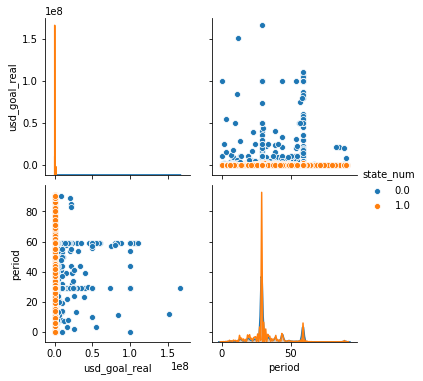

In [14]:
# 散布図行列
sns.pairplot(df_ks_trans.loc[:,["usd_goal_real","state_num","period"]],hue="state_num")

In [15]:
# 相関係数を確認
df_ks_trans.loc[:,["usd_goal_real","state_num","period"]].corr()

,usd_goal_real,state_num,period
usd_goal_real,1.000000,-0.023735,0.021607
state_num,-0.023735,1.000000,-0.116437
period,0.021607,-0.116437,1.000000


カテゴリ変数は相関がないので除外して確認

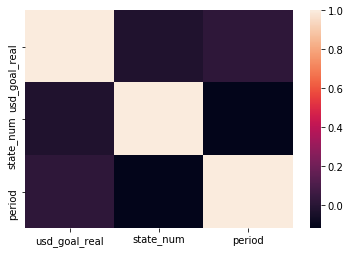

In [16]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_ks_trans.loc[:,["usd_goal_real","state_num","period"]].corr())
plt.show()

相関の強い変数は無さそう

#### ロジスティック回帰

In [17]:
#print(df_ks_trans.head())
#目的変数と説明変数を抽出
y=df_ks_trans.loc[:,['state_num']].values
X=df_ks_trans.drop(columns='state_num').values

clf=SGDClassifier(loss='log',penalty='none',max_iter=1000,
                 fit_intercept=True,random_state=1234,tol=1e-3)
#学習
clf.fit(X,y)

#予測
y_est=clf.predict(X)

#確率値
y_est_proba = clf.predict_proba(X)

#対数尤度
print('対数尤度={:.3f}'.format(-log_loss(y,y_est_proba,normalize=False)))

d1_SGD_accuracy=accuracy_score(y,y_est)
#正答率
print('正答率={:.3f}%'.format(100*d1_SGD_accuracy))

#予測値と正解のクロス集計
conf_mat=pd.DataFrame(confusion_matrix(y,y_est),
                     index=['正解=failed','正解=successful'],
                     columns=['予測=failed','予測=successful'])
conf_mat

C:\Users\mura\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


対数尤度=-5112291.527
正答率=55.373%


,予測=failed,予測=successful
正解=failed,83239,114480
正解=successful,33536,100420


#### Day2 ホールドアウト法・交差検証、標準化とSVM

- SVMで学習・予測(ハイパーパラメータを手動設定)

In [18]:
def SVM_manual(X_train_stand_SVC,y_train_SVC,X_test_stand_SVC,y_test_SVC):

    """
    X_train_stand_SVC:標準化済み学習データ目的変数
    y_train_SVC：学習データ説明変数
    X_test_stand_SVC：標準化済み予測データ目的変数
    y_test_SVC : 予測データ説明変数
    """
    print('SVMで学習・予測(ハイパーパラメータを手動設定**********************************')

    #ハイパーパラメータ
    C = 5
    kernel = "rbf"
    gamma = "scale"
    #学習
    clf_SVC=SVC(C=C, kernel=kernel, gamma=gamma)
    clf_SVC.fit(X_train_stand_SVC,y_train_SVC)

    #予測
    y_est_SVC=clf_SVC.predict(X_test_stand_SVC)

    #正答率
    accuracy_SVC=accuracy_score(y_test_SVC,y_est_SVC)
    print('正答率(Accuracy) = {:.3f}%'.format(100*accuracy_SVC))

    #Precision,Recall,F1-score
    precision_SVC,recall_SVC,f1_score_SVC,_=precision_recall_fscore_support(y_test_SVC,y_est_SVC)
    print('適合率(Precision)={:.3f}%'.format(100*precision_SVC[1]))
    print('再現率(Recall)={:.3f}%'.format(100*recall_SVC[1]))
    print('F1値(F1-score)={:.3f}%'.format(100*f1_score_SVC[1]))

    #予測値と正解のクロス集計
    conf_mat_SVC=pd.DataFrame(confusion_matrix(y_test_SVC,y_est_SVC),
                         index=['正解=failed','正解=successful'],
                         columns=['予測=failed','予測=successful'])
    print(conf_mat_SVC)
    
    return accuracy_SVC

- SVMで学習・予測(グリッドサーチ)

In [19]:
def SVC_GridS(X_train_stand_GriS,y_train_GriS,X_test_stand_GriS,y_test_GriS):

    """
    X_train_stand_GriS:標準化済み学習データ目的変数
    y_train_GriS：学習データ説明変数
    X_test_stand_GriS：標準化済み予測データ目的変数
    y_test_GriS : 予測データ説明変数
    """
    print('SVMで学習・予測(グリッドサーチ)**********************************')

    #パラメータ候補設定とパラメータの学習
    parameters = {'kernel':['rbf','linear'], 'C':[1, 5, 10]}
    model = SVC(gamma="scale") #gamma自動計算
    clf_GriS = GridSearchCV(model, parameters, cv=3,)
    clf_GriS.fit(X_train_stand_GriS, y_train_GriS)
    print(clf_GriS.best_params_, clf_GriS.best_score_)

    # 最適パラメータを用いて識別する
    clf2_GriS = SVC(**clf_GriS.best_params_, gamma="scale") # gamma=scaleにすると、gammaが自動で計算される
    clf2_GriS.fit(X_train_stand_GriS, y_train_GriS)
    print("識別精度=",clf2_GriS.score(X_test_stand_GriS, y_test_GriS))

    #予測
    y_est_GriS=clf2_GriS.predict(X_test_stand_GriS)

    #正答率
    accuracy_GriS=accuracy_score(y_test_GriS,y_est_GriS)
    print('正答率(Accuracy) = {:.3f}%'.format(100*accuracy_GriS))

    #Precision,Recall,F1-score
    precision_GriS,recall_GriS,f1_score_GriS,_=precision_recall_fscore_support(y_test_GriS,y_est_GriS)
    print('適合率(Precision)={:.3f}%'.format(100*precision_GriS[1]))
    print('再現率(Recall)={:.3f}%'.format(100*recall_GriS[1]))
    print('F1値(F1-score)={:.3f}%'.format(100*f1_score_GriS[1]))

    #予測値と正解のクロス集計
    conf_mat_GriS=pd.DataFrame(confusion_matrix(y_test_GriS,y_est_GriS),
                         index=['正解=failed','正解=successful'],
                         columns=['予測=failed','予測=successful'])
    print(conf_mat_GriS)
    
    return accuracy_GriS


- ロジスティック回帰

In [20]:
def SGD(X_train_stand_SGD,y_train_SGD,X_test_stand_SGD,y_test_SGD):

    """
    X_train_stand_SGD:標準化済み学習データ目的変数
    y_train_SGD：学習データ説明変数
    X_test_stand_SGD：標準化済み予測データ目的変数
    y_test_SGD : 予測データ説明変数
    """
    print('ロジスティック回帰学習**********************************')

    #学習
    clf_SGD=SGDClassifier(loss='log',penalty='none',max_iter=1000,
                     fit_intercept=True,random_state=1234,tol=1e-3)
    clf_SGD.fit(X_train_stand_SGD,y_train_SGD)

    #予測
    y_est_SGD=clf_SGD.predict(X_test_stand_SGD)

    #正答率
    accuracy_SGD=accuracy_score(y_test_SGD,y_est_SGD)
    print('正答率(Accuracy) = {:.3f}%'.format(100*accuracy_SGD))

    #Precision,Recall,F1-score
    precision_SGD,recall_SGD,f1_score_SGD,_=precision_recall_fscore_support(y_test_SGD,y_est_SGD)
    print('適合率(Precision)={:.3f}%'.format(100*precision_SGD[1]))
    print('再現率(Recall)={:.3f}%'.format(100*recall_SGD[1]))
    print('F1値(F1-score)={:.3f}%'.format(100*f1_score_SGD[1]))

    #予測値と正解のクロス集計
    conf_mat_SGD=pd.DataFrame(confusion_matrix(y_test_SGD,y_est_SGD),
                         index=['正解=failed','正解=successful'],
                         columns=['予測=failed','予測=successful'])
    print(conf_mat_SGD)
    
    return accuracy_SGD


#### ホールドアウト法

SVM(ハイパーパラメータ手動設定)

In [21]:
#ホールドアウト法

#SVMで全件学習・予測できなかったのでデータを絞る
df_ks_extra=df_ks_trans.iloc[:1000,:]

#説明変数と目的変数を設定
df_X=df_ks_extra.drop('state_num',axis=1)
X, y = df_X.values, df_ks_extra["state_num"].values

#ホールドアウト法を実行
test_size = 0.2        # テストデータの割合
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

#学習用データを使って標準化
stdsc=StandardScaler()
X_train_stand=stdsc.fit_transform(X_train)
X_test_stand=stdsc.transform(X_test)

#標準化したデータを確認
df_train_std = pd.DataFrame(X_train_stand, columns=df_X.columns)
print(df_train_std.describe())
df_test_std = pd.DataFrame(X_test_stand, columns=df_X.columns)
print(df_test_std.describe())

#SVM（パラメータ手動設定）
d2_h_final_SVM_manual_accuracy=SVM_manual(X_train_stand,y_train,X_test_stand,y_test)


       usd_goal_real            AT            AU            BE            CA  \
count   8.000000e+02  8.000000e+02  8.000000e+02  8.000000e+02  8.000000e+02   
mean   -3.198830e-17  4.823399e-16 -2.509104e-16  9.936496e-17 -2.129547e-16   
std     1.000626e+00  1.000626e+00  1.000626e+00  1.000626e+00  1.000626e+00   
min    -2.612337e-01 -5.006262e-02 -1.125088e-01 -5.006262e-02 -1.720495e-01   
25%    -2.392041e-01 -5.006262e-02 -1.125088e-01 -5.006262e-02 -1.720495e-01   
50%    -2.061432e-01 -5.006262e-02 -1.125088e-01 -5.006262e-02 -1.720495e-01   
75%    -9.594026e-02 -5.006262e-02 -1.125088e-01 -5.006262e-02 -1.720495e-01   
max     1.737970e+01  1.997498e+01  8.888194e+00  1.997498e+01  5.812281e+00   

          CH            DE            DK            ES            FR  ...  \
count  800.0  8.000000e+02  8.000000e+02  8.000000e+02  8.000000e+02  ...   
mean     0.0  1.502271e-17  1.556914e-16  2.831242e-16  1.462719e-16  ...   
std      0.0  1.000626e+00  1.000626e+00  1.0006

SVM(グリッドサーチ)

In [22]:
#ホールドアウト法

#SVMで全件学習・予測できなかったのでデータを絞る
df_ks_extra=df_ks_trans.iloc[:1000,:]

#説明変数と目的変数を設定
df_X=df_ks_extra.drop('state_num',axis=1)
X, y = df_X.values, df_ks_extra["state_num"].values

#ホールドアウト法を実行
test_size = 0.2        # テストデータの割合
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

#学習用データを使って標準化
stdsc=StandardScaler()
X_train_stand=stdsc.fit_transform(X_train)
X_test_stand=stdsc.transform(X_test)

#SVM(グリッドサーチ)
d2_h_final_SVC_GridS_accuracy=SVC_GridS(X_train_stand,y_train,X_test_stand,y_test)


SVMで学習・予測(グリッドサーチ)**********************************
{'C': 1, 'kernel': 'rbf'} 0.56
識別精度= 0.575
正答率(Accuracy) = 57.500%
適合率(Precision)=44.444%
再現率(Recall)=47.368%
F1値(F1-score)=45.860%
               予測=failed  予測=successful
正解=failed             79             45
正解=successful         40             36


ロジスティック回帰

In [23]:
#ホールドアウト法

#全件学習・予測
df_ks_extra=df_ks_trans.iloc[:,:]

#説明変数と目的変数を設定
df_X=df_ks_extra.drop('state_num',axis=1)
X, y = df_X.values, df_ks_extra["state_num"].values

#ホールドアウト法を実行
test_size = 0.2        # テストデータの割合
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

#学習用データを使って標準化
stdsc=StandardScaler()
X_train_stand=stdsc.fit_transform(X_train)
X_test_stand=stdsc.transform(X_test)

#ロジスティック回帰
d2_h_final_SGD_accuracy=SGD(X_train_stand,y_train,X_test_stand,y_test)


ロジスティック回帰学習**********************************
正答率(Accuracy) = 66.650%
適合率(Precision)=60.007%
再現率(Recall)=50.528%
F1値(F1-score)=54.861%
               予測=failed  予測=successful
正解=failed          30768           8960
正解=successful      13163          13444


In [24]:
print("Holdout SVM manual 正答率(Accuracy) = {:.3f}%".format(100*d2_h_final_SVM_manual_accuracy))
print("Holdout SVM gridsearch 正答率(Accuracy) = {:.3f}%".format(100*d2_h_final_SVC_GridS_accuracy))
print("Holdout SGD 正答率(Accuracy) = {:.3f}%".format(100*d2_h_final_SGD_accuracy))


Holdout SVM manual 正答率(Accuracy) = 58.000%
Holdout SVM gridsearch 正答率(Accuracy) = 57.500%
Holdout SGD 正答率(Accuracy) = 66.650%


#### 交差検証

SVM(ハイパーパラメータ手動設定)

In [25]:
#SVMで全件学習・予測できなかったのでデータを絞る
df_ks_extra=df_ks_trans.iloc[:1000,:]

#説明変数と目的変数を設定
df_X=df_ks_extra.drop('state_num',axis=1)
X, y = df_X.values, df_ks_extra["state_num"].values

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
cross_SVM_manual_accuracy = 0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    
    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)

    #SVM（パラメータ手動設定）
    accuracy_SVM_manual=SVM_manual(X_train_stand,y_train,X_test_stand,y_test)

    cross_SVM_manual_accuracy += accuracy_SVM_manual

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d2_CV_final_SVM_manual_accuracy = cross_SVM_manual_accuracy / n_split


SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 58.000%
適合率(Precision)=45.652%
再現率(Recall)=55.263%
F1値(F1-score)=50.000%
               予測=failed  予測=successful
正解=failed             74             50
正解=successful         34             42
SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 57.000%
適合率(Precision)=49.425%
再現率(Recall)=50.588%
F1値(F1-score)=50.000%
               予測=failed  予測=successful
正解=failed             71             44
正解=successful         42             43
SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 59.500%
適合率(Precision)=56.716%
再現率(Recall)=42.222%
F1値(F1-score)=48.408%
               予測=failed  予測=successful
正解=failed             81             29
正解=successful         52             38
SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 56.500%
適合率(Precision)=51.163%
再現率(Recall)=49.438%
F1値(F1-score)=50.286%
               予測=failed  予測=successful
正解=faile

SVMで学習・予測(グリッドサーチ)

In [26]:
#SVMで全件学習・予測できなかったのでデータを絞る
df_ks_extra=df_ks_trans.iloc[:1000,:]

#説明変数と目的変数を設定
df_X=df_ks_extra.drop('state_num',axis=1)
X, y = df_X.values, df_ks_extra["state_num"].values

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
cross_SVC_GridS_accuracy = 0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    
    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)

    #SVM(グリッドサーチ)
    accuracy_SVC_GridS=SVC_GridS(X_train_stand,y_train,X_test_stand,y_test)

    cross_SVC_GridS_accuracy += accuracy_SVC_GridS

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d2_CV_final_SVC_GridS_accuracy = cross_SVC_GridS_accuracy / n_split


SVMで学習・予測(グリッドサーチ)**********************************
{'C': 1, 'kernel': 'rbf'} 0.55625
識別精度= 0.575
正答率(Accuracy) = 57.500%
適合率(Precision)=44.444%
再現率(Recall)=47.368%
F1値(F1-score)=45.860%
               予測=failed  予測=successful
正解=failed             79             45
正解=successful         40             36
SVMで学習・予測(グリッドサーチ)**********************************
{'C': 1, 'kernel': 'rbf'} 0.5925
識別精度= 0.575
正答率(Accuracy) = 57.500%
適合率(Precision)=50.000%
再現率(Recall)=48.235%
F1値(F1-score)=49.102%
               予測=failed  予測=successful
正解=failed             74             41
正解=successful         44             41
SVMで学習・予測(グリッドサーチ)**********************************
{'C': 1, 'kernel': 'rbf'} 0.5675
識別精度= 0.635
正答率(Accuracy) = 63.500%
適合率(Precision)=65.455%
再現率(Recall)=40.000%
F1値(F1-score)=49.655%
               予測=failed  予測=successful
正解=failed             91             19
正解=successful         54             36
SVMで学習・予測(グリッドサーチ)**********************************
{'C': 1, 'kernel': 'rbf'}

In [27]:
#全件学習・予測
df_ks_extra=df_ks_trans.iloc[:,:]

#説明変数と目的変数を設定
df_X=df_ks_extra.drop('state_num',axis=1)
X, y = df_X.values, df_ks_extra["state_num"].values

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
cross_SGD_accuracy = 0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    
    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)

    #ロジスティック回帰
    accuracy_SGD=SGD(X_train_stand,y_train,X_test_stand,y_test)

    cross_SGD_accuracy += accuracy_SGD

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d2_CV_final_SGD_accuracy = cross_SGD_accuracy / n_split


ロジスティック回帰学習**********************************
正答率(Accuracy) = 66.729%
適合率(Precision)=60.344%
再現率(Recall)=49.739%
F1値(F1-score)=54.530%
               予測=failed  予測=successful
正解=failed          31031           8697
正解=successful      13373          13234
ロジスティック回帰学習**********************************
正答率(Accuracy) = 66.417%
適合率(Precision)=60.167%
再現率(Recall)=50.633%
F1値(F1-score)=54.990%
               予測=failed  予測=successful
正解=failed          30450           9009
正解=successful      13268          13608
ロジスティック回帰学習**********************************
正答率(Accuracy) = 66.341%
適合率(Precision)=59.367%
再現率(Recall)=53.723%
F1値(F1-score)=56.404%
               予測=failed  予測=successful
正解=failed          29563           9886
正解=successful      12442          14444
ロジスティック回帰学習**********************************
正答率(Accuracy) = 66.267%
適合率(Precision)=58.871%
再現率(Recall)=54.699%
F1値(F1-score)=56.708%
               予測=failed  予測=successful
正解=failed          29302          10239
正解=successful      1

In [28]:
print("Cross Validation SVM manual 正答率(Accuracy) = {:.3f}%".format(100*d2_CV_final_SVM_manual_accuracy))
print("Cross Validation SVM gridsearch 正答率(Accuracy) = {:.3f}%".format(100*d2_CV_final_SVC_GridS_accuracy))
print("Cross Validation SGD 正答率(Accuracy) = {:.3f}%".format(100*d2_CV_final_SGD_accuracy))


Cross Validation SVM manual 正答率(Accuracy) = 56.800%
Cross Validation SVM gridsearch 正答率(Accuracy) = 57.800%
Cross Validation SGD 正答率(Accuracy) = 66.377%


In [29]:
print('Day1 ロジスティック回帰　正答率={:.3f}%'.format(100*d1_SGD_accuracy))
print("Day2 ホールドアウト法　SVM ハイパーパラメータ手動設定 正答率 = {:.3f}%".format(100*d2_h_final_SVM_manual_accuracy))
print("Day2 ホールドアウト法　SVM グリッドサーチ　正答率 = {:.3f}%".format(100*d2_h_final_SVC_GridS_accuracy))
print("Day2 ホールドアウト法　ロジスティック回帰　正答率 = {:.3f}%".format(100*d2_h_final_SGD_accuracy))
print("Day2 交差検証　SVM ハイパーパラメータ手動設定 正答率 = {:.3f}%".format(100*d2_CV_final_SVM_manual_accuracy))
print("Day2 交差検証　SVM グリッドサーチ　正答率 = {:.3f}%".format(100*d2_CV_final_SVC_GridS_accuracy))
print("Day2 交差検証　ロジスティック回帰　正答率 = {:.3f}%".format(100*d2_CV_final_SGD_accuracy))


Day1 ロジスティック回帰　正答率=55.373%
Day2 ホールドアウト法　SVM ハイパーパラメータ手動設定 正答率 = 58.000%
Day2 ホールドアウト法　SVM グリッドサーチ　正答率 = 57.500%
Day2 ホールドアウト法　ロジスティック回帰　正答率 = 66.650%
Day2 交差検証　SVM ハイパーパラメータ手動設定 正答率 = 56.800%
Day2 交差検証　SVM グリッドサーチ　正答率 = 57.800%
Day2 交差検証　ロジスティック回帰　正答率 = 66.377%


SVMは全データで学習に時間がかかるため、先頭から1000件を抽出して実施

#### Day3 特徴選択、ランダムフォレスト、NN

ラッパー法による特徴選択（ステップワイズ法）

In [30]:
# from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFECV

#モデルを選択(ロジスティック回帰)
estimator=SGDClassifier(loss='log',penalty='none',max_iter=1000,
                     fit_intercept=True,random_state=1234,tol=1e-3)

rfecv=RFECV(estimator,cv=10,scoring='accuracy')

#全件学習・選択できなかったのでデータを絞る
#df_ks_rfecv=df_ks_trans.iloc[:,:]
df_ks_rfecv=df_ks_trans.iloc[:1000,:]

#説明変数と目的変数を設定
df_X=df_ks_rfecv.drop('state_num',axis=1)

X, y = df_X.values, df_ks_rfecv["state_num"].values

rfecv.fit(X,y)

print('Feature ranking: \n{}'.format(rfecv.ranking_))


Feature ranking: 
[  1 150  79 132  54  93  82 169  99 138   7  50 164  97 192 191 122 190
 124 166 103  86 181   2  74 182  75 100 151 157  67  33  70 128  21  38
 186 127 162 198  73 196  91  25 120 177 185 101  52  39  37 143 156 105
  44 199  81 207 109  65  30  57 106  36  55  43 137 155 113  58  85  89
  64 114 160 116  41  69 146  42 111 148  32  90  80 118  94 173 174 168
 141  62 153 131  35 183  12 110 171  63 119  49 204  83 140 210 211 209
 136 152 139 117 158 135  13 115  96  34 172  59 159 147  68 161 142 201
 188  46  56  76  47  61  45  22 194 133 203  10  26 165 195  98 189 129
 112 121 176  48 178  29 193 104  72  18 163 107 154 200  88 149  11 202
  27 175 179  23 126 197 184 144 108 205  24  77 206  66 145  71 134 187
 125 130  95   8  19  84  28   9  20   4  17   5  40   3  31  16  14  15
  78  53  92 180  60   6  51 170 123 167 102  87 208   1   1]


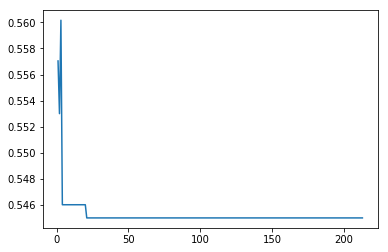

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [31]:
#特徴のスコアを表示
plt.plot(range(1,len(rfecv.grid_scores_)+1),rfecv.grid_scores_)
plt.show()

rfecv.support_

In [32]:
#削除する列を指定
remove_idx=~rfecv.support_
remove_feature=df_X.columns[remove_idx]
print(remove_feature)

#列を削除
df_select_ks=df_ks_rfecv.drop(remove_feature,axis=1)
print(df_select_ks.info())

Index(['AT', 'AU', 'BE', 'CA', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB',
       ...
       'DKK', 'EUR', 'GBP', 'HKD', 'JPY', 'MXN', 'NOK', 'NZD', 'SEK', 'SGD'],
      dtype='object', length=210)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
usd_goal_real    1000 non-null float64
state_num        1000 non-null float64
USD              1000 non-null float64
period           1000 non-null int64
dtypes: float64(3), int64(1)
memory usage: 31.3 KB
None


Lassoによる特徴選択

In [33]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

#全件学習・選択
df_ks_lasso=df_ks_trans.iloc[:,:]

#説明変数と目的変数を設定
df_X=df_ks_lasso.drop('state_num',axis=1)

X, y = df_X.values, df_ks_lasso["state_num"].values

estimator = LassoCV(normalize=True,cv=5,max_iter=10000)
sfm=SelectFromModel(estimator,threshold=1e-1)

#特徴選択を実行
sfm.fit(X,y)


SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=0.1)

In [34]:
#特徴選択結果
print("特徴の使用・不使用(trueが使用する特徴)")
print(sfm.get_support())

#削除する特徴の変数名を取得
removed_idx=~sfm.get_support()
df_drop_X=df_X.columns[removed_idx]
print("削除する変数の名前")
print(df_drop_X)

#各特徴の係数の絶対値を取得
abs_coef=np.abs(sfm.estimator_.coef_)
print(abs_coef)

特徴の使用・不使用(trueが使用する特徴)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True  True  True False False  True False  True  True False  True
 False  True False False  True  True False False False  True False  True
 False  True False False False False  True False False False False  True
  True False False False False False  True False  True False False False
  True False  True False False False  True False False False False  True
  True False False False False False False False  True False  True False
  True  True  True  True False False False  True  True  True  True  True
  True False False False  True False False False False False  True False
 False  True False  True False False  True False False  True  True False
 False False  True  True False False  True False False False False  True
 False False  True  True  True False False False False  True False  True
  True  True False  True  Tr

In [35]:
#列を削除
df_select_ks=df_X.drop(df_drop_X,axis=1)
print(df_select_ks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331675 entries, 0 to 331674
Data columns (total 63 columns):
3D Printing           331675 non-null float64
Academic              331675 non-null float64
Accessories           331675 non-null float64
Action                331675 non-null float64
Anthologies           331675 non-null float64
Apps                  331675 non-null float64
Architecture          331675 non-null float64
Art Books             331675 non-null float64
Bacon                 331675 non-null float64
Camera Equipment      331675 non-null float64
Candles               331675 non-null float64
Chiptune              331675 non-null float64
Classical Music       331675 non-null float64
Comic Books           331675 non-null float64
Country & Folk        331675 non-null float64
DIY Electronics       331675 non-null float64
Electronic Music      331675 non-null float64
Events                331675 non-null float64
Family                331675 non-null float64
Farmer's Market

In [36]:
#特徴選択後の情報
df_select_ks.head()

,3D Printing,Academic,Accessories,Action,Anthologies,Apps,Architecture,Art Books,Bacon,Camera Equipment,...,Stationery,Tabletop Games,Taxidermy,Television,Typography,Video,Video Games,Web,Young Adult,Zines
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


アダブースト（決定木）

In [37]:
def AdaB(X_train_stand_AdaB,y_train_AdaB,X_test_stand_AdaB,y_test_AdaB):

    """
    X_train_stand_SGD:標準化済み学習データ目的変数
    y_train_SGD：学習データ説明変数
    X_test_stand_SGD：標準化済み予測データ目的変数
    y_test_SGD : 予測データ説明変数
    """
    print('アダブースト（決定木）**********************************')

    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.tree import DecisionTreeClassifier

    #決定木を指定してアダブースト
    clf_AdaB=AdaBoostClassifier(DecisionTreeClassifier(max_depth=None,
                                                      min_samples_leaf=10,
                                                      min_samples_split=10,
                                                      random_state=1234,
                                                      criterion="gini"),
                                                      n_estimators=500,random_state=1234)
    clf_AdaB.fit(X_train_stand_AdaB,y_train_AdaB)
    print("score=",clf_AdaB.score(X_train_stand_AdaB,y_train_AdaB))    
    
    #予測
    y_est_AdaB=clf_AdaB.predict(X_test_stand_AdaB)

    #正答率
    accuracy_AdaB=accuracy_score(y_test_AdaB,y_est_AdaB)
    print('正答率(Accuracy) = {:.3f}%'.format(100*accuracy_AdaB))

    #Precision,Recall,F1-score
    precision_AdaB,recall_AdaB,f1_score_AdaB,_=precision_recall_fscore_support(y_test_AdaB,y_est_AdaB)
    print('適合率(Precision)={:.3f}%'.format(100*precision_AdaB[1]))
    print('再現率(Recall)={:.3f}%'.format(100*recall_AdaB[1]))
    print('F1値(F1-score)={:.3f}%'.format(100*f1_score_AdaB[1]))

    #予測値と正解のクロス集計
    conf_mat_AdaB=pd.DataFrame(confusion_matrix(y_test_AdaB,y_est_AdaB),
                         index=['正解=failed','正解=successful'],
                         columns=['予測=failed','予測=successful'])
    print(conf_mat_AdaB)
    
    return accuracy_AdaB


決定木

score= 0.59625
Index(['3D Printing', 'Academic', 'Accessories', 'Action', 'Anthologies',
       'Apps', 'Architecture', 'Art Books', 'Bacon', 'Camera Equipment',
       'Candles', 'Chiptune', 'Classical Music', 'Comic Books',
       'Country & Folk', 'DIY Electronics', 'Electronic Music', 'Events',
       'Family', 'Farmer's Markets', 'Fiction', 'Food Trucks', 'Footwear',
       'Hip-Hop', 'Illustration', 'Indie Rock', 'Installations',
       'Interactive Design', 'Jazz', 'Knitting', 'Latin', 'Letterpress',
       'Literary Journals', 'Literary Spaces', 'Live Games', 'Mobile Games',
       'Nature', 'People', 'Performances', 'Photo', 'Places', 'Playing Cards',
       'Pottery', 'Print', 'Public Art', 'R&B', 'Residencies', 'Restaurants',
       'Robots', 'Shorts', 'Software', 'Sound', 'Space Exploration',
       'Stationery', 'Tabletop Games', 'Taxidermy', 'Television', 'Typography',
       'Video', 'Video Games', 'Web', 'Young Adult', 'Zines'],
      dtype='object')
[0.         0.     

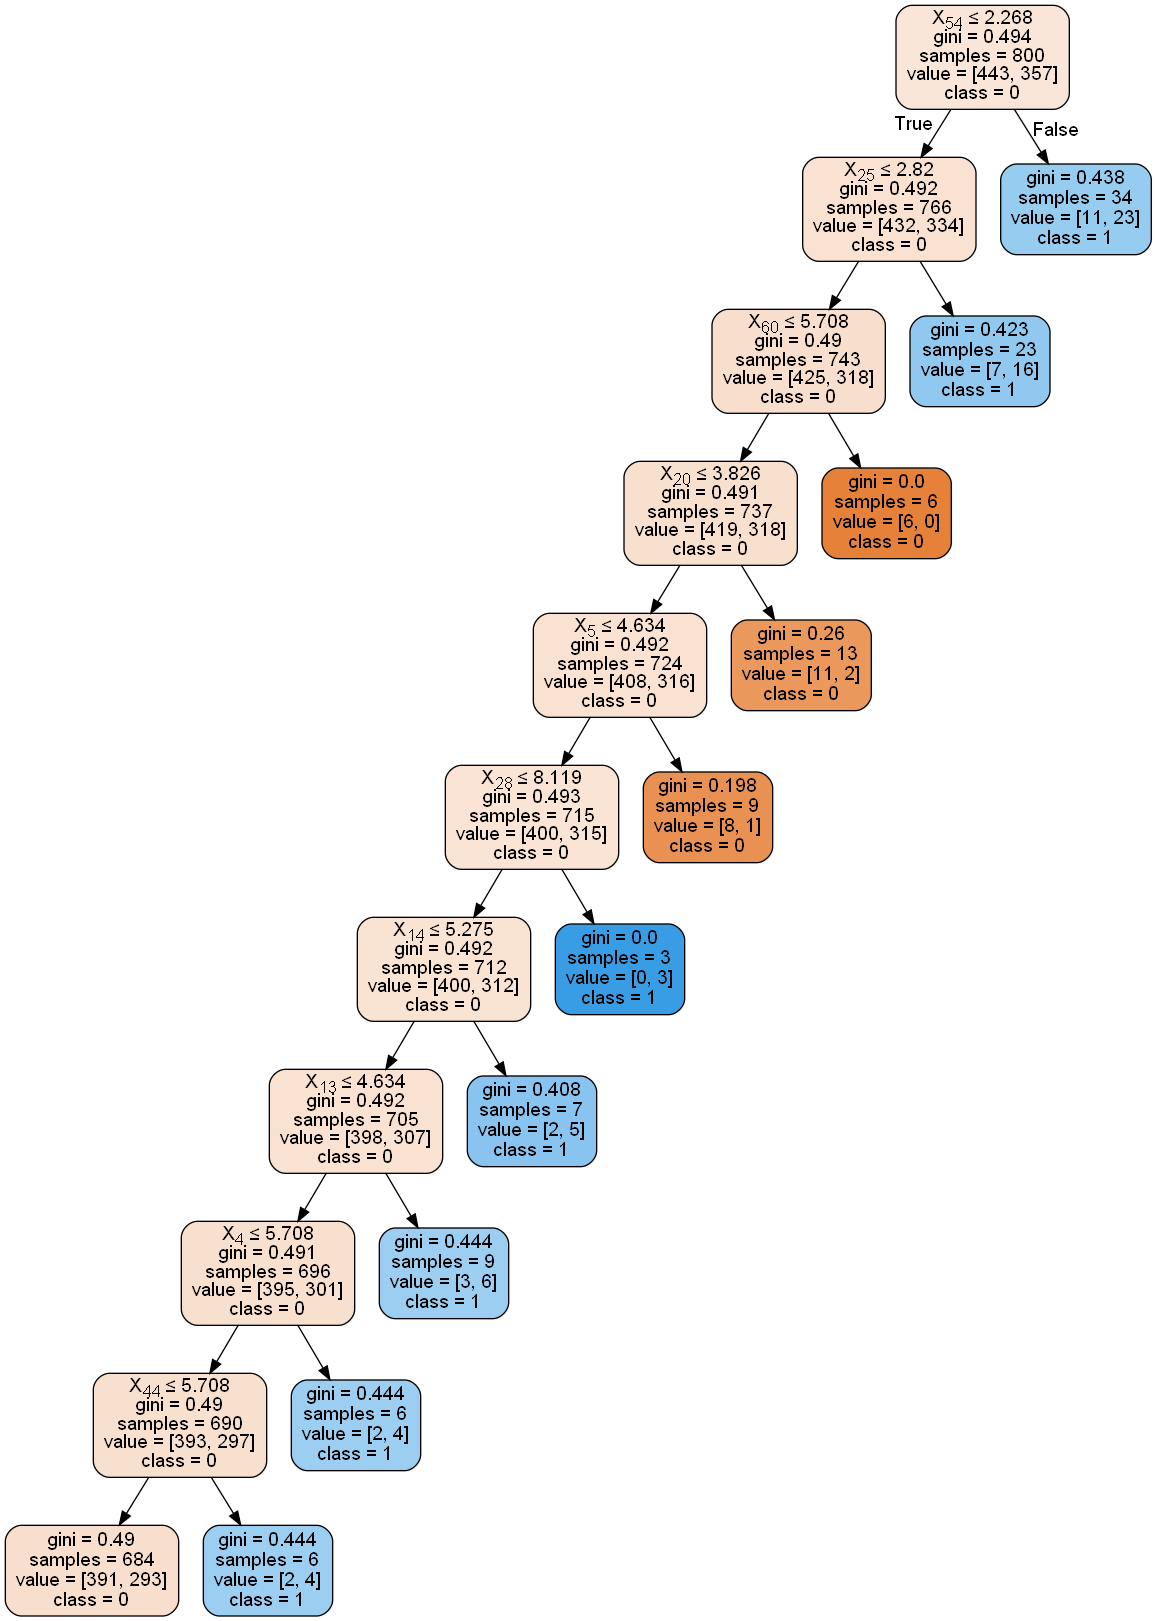

In [38]:
#決定木
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO

#特徴選択後のデータを絞る
df_ks_extra=df_select_ks.loc[:1000,:]

#説明変数と目的変数を設定
df_X=df_ks_extra
X, y = df_X.values, df_ks_lasso.loc[:1000,"state_num"].values

#ホールドアウト法を実行
test_size = 0.2        # テストデータの割合
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

#学習用データを使って標準化
stdsc=StandardScaler()
X_train_stand=stdsc.fit_transform(X_train)
X_test_stand=stdsc.transform(X_test)

clf = DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_leaf=3, random_state=1234)
clf = clf.fit(X_train_stand, y_train)
print("score=", clf.score(X_train_stand, y_train))
print(df_X.columns)
print(clf.feature_importances_)


# 決定木の描画
dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(clf, out_file=dot_data,  
#                     feature_names=df_X.columns,  
                     class_names=["0","1"],  
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

特徴選択後　交差検証　SVM（ハイパーパラメータ手動設定）

In [39]:
#全件学習できなかったのでデータを絞る
df_ks_extra=df_select_ks.iloc[:1000,:]

#説明変数と目的変数を設定
df_X=df_ks_extra
X, y = df_X.values, df_ks_lasso.loc[:999,"state_num"].values
print(X.shape)
print(y.shape)

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
cross_SVM_manual_accuracy = 0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    
    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)

    #SVM（パラメータ手動設定）
    accuracy_SVM_manual=SVM_manual(X_train_stand,y_train,X_test_stand,y_test)

    cross_SVM_manual_accuracy += accuracy_SVM_manual

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d3_CV_final_SVM_manual_accuracy = cross_SVM_manual_accuracy / n_split


(1000, 63)
(1000,)
SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 63.500%
適合率(Precision)=55.172%
再現率(Recall)=21.053%
F1値(F1-score)=30.476%
               予測=failed  予測=successful
正解=failed            111             13
正解=successful         60             16
SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 60.500%
適合率(Precision)=57.143%
再現率(Recall)=28.235%
F1値(F1-score)=37.795%
               予測=failed  予測=successful
正解=failed             97             18
正解=successful         61             24
SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 59.000%
適合率(Precision)=66.667%
再現率(Recall)=17.778%
F1値(F1-score)=28.070%
               予測=failed  予測=successful
正解=failed            102              8
正解=successful         74             16
SVMで学習・予測(ハイパーパラメータを手動設定**********************************
正答率(Accuracy) = 59.000%
適合率(Precision)=60.606%
再現率(Recall)=22.472%
F1値(F1-score)=32.787%
               予測=failed  予測=

特徴選択後　交差検証　SVM(グリッドサーチ)

In [40]:
#全件学習できなかったのでデータを絞る
df_ks_extra=df_select_ks.iloc[:1000,:]

#説明変数と目的変数を設定
df_X=df_ks_extra
X, y = df_X.values, df_ks_lasso.loc[:999,"state_num"].values
print(X.shape)
print(y.shape)

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
cross_SVC_GridS_accuracy = 0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    
    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)

    #SVM(グリッドサーチ)
    accuracy_SVC_GridS=SVC_GridS(X_train_stand,y_train,X_test_stand,y_test)

    cross_SVC_GridS_accuracy += accuracy_SVC_GridS

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d3_CV_final_SVC_GridS_accuracy = cross_SVC_GridS_accuracy / n_split


(1000, 63)
(1000,)
SVMで学習・予測(グリッドサーチ)**********************************
{'C': 1, 'kernel': 'rbf'} 0.57
識別精度= 0.635
正答率(Accuracy) = 63.500%
適合率(Precision)=55.172%
再現率(Recall)=21.053%
F1値(F1-score)=30.476%
               予測=failed  予測=successful
正解=failed            111             13
正解=successful         60             16
SVMで学習・予測(グリッドサーチ)**********************************
{'C': 5, 'kernel': 'rbf'} 0.59625
識別精度= 0.605
正答率(Accuracy) = 60.500%
適合率(Precision)=57.143%
再現率(Recall)=28.235%
F1値(F1-score)=37.795%
               予測=failed  予測=successful
正解=failed             97             18
正解=successful         61             24
SVMで学習・予測(グリッドサーチ)**********************************
{'C': 1, 'kernel': 'rbf'} 0.59875
識別精度= 0.59
正答率(Accuracy) = 59.000%
適合率(Precision)=66.667%
再現率(Recall)=17.778%
F1値(F1-score)=28.070%
               予測=failed  予測=successful
正解=failed            102              8
正解=successful         74             16
SVMで学習・予測(グリッドサーチ)**********************************
{'C': 1,

特徴選択後　交差検証　ロジスティック回帰

In [41]:
#全件学習
df_ks_extra=df_select_ks.iloc[:,:]

#説明変数と目的変数を設定
df_X=df_ks_extra
X, y = df_X.values, df_ks_lasso["state_num"].values
print(X.shape)
print(y.shape)

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
cross_SGD_accuracy = 0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    
    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)

    #ロジスティック回帰
    accuracy_SGD=SGD(X_train_stand,y_train,X_test_stand,y_test)

    cross_SGD_accuracy += accuracy_SGD

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d3_CV_final_SGD_accuracy = cross_SGD_accuracy / n_split


(331675, 63)
(331675,)
ロジスティック回帰学習**********************************
正答率(Accuracy) = 63.389%
適合率(Precision)=61.383%
再現率(Recall)=23.520%
F1値(F1-score)=34.009%
               予測=failed  予測=successful
正解=failed          35791           3937
正解=successful      20349           6258
ロジスティック回帰学習**********************************
正答率(Accuracy) = 63.081%
適合率(Precision)=60.638%
再現率(Recall)=25.301%
F1値(F1-score)=35.705%
               予測=failed  予測=successful
正解=failed          35045           4414
正解=successful      20076           6800
ロジスティック回帰学習**********************************
正答率(Accuracy) = 63.244%
適合率(Precision)=63.066%
再現率(Recall)=22.476%
F1値(F1-score)=33.141%
               予測=failed  予測=successful
正解=failed          35910           3539
正解=successful      20843           6043
ロジスティック回帰学習**********************************
正答率(Accuracy) = 63.534%
適合率(Precision)=63.423%
再現率(Recall)=22.960%
F1値(F1-score)=33.715%
               予測=failed  予測=successful
正解=failed          35993           35

特徴選択後　交差検証　アダブースト（決定木）

In [42]:
#全件学習できなかったのでデータを絞る
df_ks_extra=df_select_ks.iloc[:1000,:]

#説明変数と目的変数を設定
df_X=df_ks_extra
X, y = df_X.values, df_ks_lasso.loc[:999,"state_num"].values
print(X.shape)
print(y.shape)

#交差検証用にデータを分割
n_split = 5 #グループ数

#変数初期化
cross_AdaB_accuracy=0
split_num = 1

#テスト役を交代させながら学習と評価

for train_idx, test_idx in KFold(n_splits=n_split,shuffle=True,random_state=1234).split(X, y):

    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test,y_test=X[test_idx],y[test_idx] #テスト用データ
    
    #学習用データを使って標準化
    stdsc=StandardScaler()
    X_train_stand=stdsc.fit_transform(X_train)
    X_test_stand=stdsc.transform(X_test)

    #アダブースト（決定木）
    accuracy_AdaB=AdaB(X_train_stand,y_train,X_test_stand,y_test)

    cross_AdaB_accuracy += accuracy_AdaB

    split_num += 1

#accuracyの平均値を最終的な正答率とする
d3_CV_final_AdaB_accuracy = cross_AdaB_accuracy / n_split


(1000, 63)
(1000,)
アダブースト（決定木）**********************************
score= 0.58375
正答率(Accuracy) = 62.500%
適合率(Precision)=53.846%
再現率(Recall)=9.211%
F1値(F1-score)=15.730%
               予測=failed  予測=successful
正解=failed            118              6
正解=successful         69              7
アダブースト（決定木）**********************************
score= 0.5975
正答率(Accuracy) = 60.000%
適合率(Precision)=58.065%
再現率(Recall)=21.176%
F1値(F1-score)=31.034%
               予測=failed  予測=successful
正解=failed            102             13
正解=successful         67             18
アダブースト（決定木）**********************************
score= 0.595
正答率(Accuracy) = 58.000%
適合率(Precision)=75.000%
再現率(Recall)=10.000%
F1値(F1-score)=17.647%
               予測=failed  予測=successful
正解=failed            107              3
正解=successful         81              9
アダブースト（決定木）**********************************
score= 0.59375
正答率(Accuracy) = 58.500%
適合率(Precision)=63.636%
再現率(Recall)=15.730%
F1値(F1-score)=25.225%
               予測=failed 

ニューラルネットワーク

In [43]:
from tensorflow import keras
import tensorflow as tf

from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense,Dropout,Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop,Adagrad,Adadelta,Adam

#全件学習
df_ks_extra=df_select_ks.iloc[:,:]

#説明変数と目的変数を設定
df_X=df_ks_extra
X, y = df_X.values, df_ks_lasso["state_num"].values
print(X.shape)
print(y.shape)

#ホールドアウト法を実行
test_size = 0.2        # テストデータの割合
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

#学習用データを使って標準化
stdsc=StandardScaler()
X_train_stand=stdsc.fit_transform(X_train)
X_test_stand=stdsc.transform(X_test)

print(X_train_stand.shape)
print(y_train.shape)
print(X_test_stand.shape)
print(y_test.shape)

#モデルをつくる
model=Sequential()
model.add(Dense(48,activation='relu',input_dim=X_train_stand.shape[1]))
model.add(Dense(24,activation='relu',input_dim=48))
model.add(Dense(8,activation='relu',input_dim=24))
model.add(Dense(2,activation='softmax'))

#最適化手法
#sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam=Adam(lr=0.01)

model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])



(331675, 63)
(331675,)
(265340, 63)
(265340,)
(66335, 63)
(66335,)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [44]:
fit = model.fit(X_train_stand,y_train,
                epochs=50,
                batch_size=1000,
                validation_data=(X_test_stand,y_test))


Train on 265340 samples, validate on 66335 samples
Epoch 1/50
265340/265340 [==============================] - 0s 2us/sample - loss: 0.6445 - acc: 0.6327 - val_loss: 0.6413 - val_acc: 0.6355
Epoch 2/50
265340/265340 [==============================] - 0s 2us/sample - loss: 0.6422 - acc: 0.6347 - val_loss: 0.6424 - val_acc: 0.6354
Epoch 3/50
265340/265340 [==============================] - 0s 2us/sample - loss: 0.6419 - acc: 0.6345 - val_loss: 0.6419 - val_acc: 0.6350
Epoch 4/50
265340/265340 [==============================] - 0s 2us/sample - loss: 0.6417 - acc: 0.6348 - val_loss: 0.6411 - val_acc: 0.6352
Epoch 5/50
265340/265340 [==============================] - 0s 2us/sample - loss: 0.6417 - acc: 0.6349 - val_loss: 0.6414 - val_acc: 0.6352
Epoch 6/50
265340/265340 [==============================] - 0s 2us/sample - loss: 0.6416 - acc: 0.6347 - val_loss: 0.6406 - val_acc: 0.6352
Epoch 7/50
265340/265340 [==============================] - 0s 2us/sample - loss: 0.6415 - acc: 0.6349 - val_

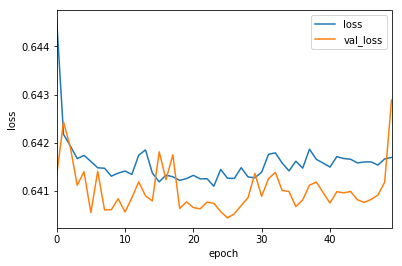

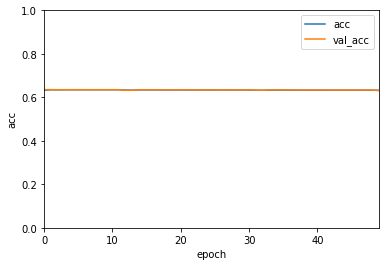

In [45]:
# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
#***loss 訓練（学習）のaccuracy　学習時の誤差
#***lossのグラフでオレンジのデータ（の誤差が）上がっている場合は過学習
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

#***acc 予測時のaccuracy 誤差（学習に使っていないデータのaccuracy）
df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [46]:
y_est_NN = np.argmax(model.predict(X_test_stand),axis=1)
print(y_est_NN)

[0 0 0 ... 0 0 0]


In [48]:
#正答率
d3_accuracy_NN=accuracy_score(y_test,y_est_NN)
print('正答率(Accuracy) = {:.3f}%'.format(100*d3_accuracy_NN))

#Precision,Recall,F1-score
precision_NN,recall_NN,f1_score_NN,_=precision_recall_fscore_support(y_test,y_est_NN)
print('適合率(Precision)={:.3f}%'.format(100*precision_NN[1]))
print('再現率(Recall)={:.3f}%'.format(100*recall_NN[1]))
print('F1値(F1-score)={:.3f}%'.format(100*f1_score_NN[1]))

#予測値と正解のクロス集計
conf_mat_NN=pd.DataFrame(confusion_matrix(y_test,y_est_NN),
                     index=['正解=failed','正解=successful'],
                     columns=['予測=failed','予測=successful'])
print(conf_mat_NN)


正答率(Accuracy) = 63.101%
適合率(Precision)=60.274%
再現率(Recall)=23.483%
F1値(F1-score)=33.798%
               予測=failed  予測=successful
正解=failed          35610           4118
正解=successful      20359           6248


特徴選択後の予測結果（SVM（手動・グリッドサーチ）、ロジスティック回帰、アダブースト（決定木））　正答率

In [54]:
print('Day1 ロジスティック回帰　正答率={:.3f}%'.format(100*d1_SGD_accuracy))
print("Day2 ホールドアウト法　SVM ハイパーパラメータ手動設定 正答率 = {:.3f}%".format(100*d2_h_final_SVM_manual_accuracy))
print("Day2 ホールドアウト法　SVM グリッドサーチ　正答率 = {:.3f}%".format(100*d2_h_final_SVC_GridS_accuracy))
print("Day2 ホールドアウト法　ロジスティック回帰　正答率 = {:.3f}%".format(100*d2_h_final_SGD_accuracy))
print("Day2 交差検証　SVM ハイパーパラメータ手動設定 正答率 = {:.3f}%".format(100*d2_CV_final_SVM_manual_accuracy))
print("Day2 交差検証　SVM グリッドサーチ　正答率 = {:.3f}%".format(100*d2_CV_final_SVC_GridS_accuracy))
print("Day2 交差検証　ロジスティック回帰　正答率 = {:.3f}%".format(100*d2_CV_final_SGD_accuracy))
print("Day3 交差検証　SVM ハイパーパラメータ手動設定 正答率 = {:.3f}%".format(100*d3_CV_final_SVM_manual_accuracy))
print("Day3 交差検証　SVM グリッドサーチ　正答率 = {:.3f}%".format(100*d3_CV_final_SVC_GridS_accuracy))
print("Day3 交差検証　ロジスティック回帰　正答率 = {:.3f}%".format(100*d3_CV_final_SGD_accuracy))
print("Day3 交差検証　アダブースト　正答率 = {:.3f}%".format(100*d3_CV_final_AdaB_accuracy))
print("Day3 ホールドアウト法　ニューラルネットワーク　正答率 = {:.3f}%".format(100*d3_accuracy_NN))


Day1 ロジスティック回帰　正答率=55.373%
Day2 ホールドアウト法　SVM ハイパーパラメータ手動設定 正答率 = 58.000%
Day2 ホールドアウト法　SVM グリッドサーチ　正答率 = 57.500%
Day2 ホールドアウト法　ロジスティック回帰　正答率 = 66.650%
Day2 交差検証　SVM ハイパーパラメータ手動設定 正答率 = 56.800%
Day2 交差検証　SVM グリッドサーチ　正答率 = 57.800%
Day2 交差検証　ロジスティック回帰　正答率 = 66.377%
Day3 交差検証　SVM ハイパーパラメータ手動設定 正答率 = 59.400%
Day3 交差検証　SVM グリッドサーチ　正答率 = 59.400%
Day3 交差検証　ロジスティック回帰　正答率 = 63.368%
Day3 交差検証　アダブースト　正答率 = 58.700%
Day3 ホールドアウト法　ニューラルネットワーク　正答率 = 63.101%


SVMは全データで学習に時間がかかるため、先頭から1000件を抽出して実施